<a href="https://colab.research.google.com/github/dminhq98/MusicGenreClassification/blob/master/implement_deep_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz 

--2020-04-23 03:37:42--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  33.6MB/s    in 0.5s    

2020-04-23 03:37:44 (33.6 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]



# MNIST dataset

## Nummpy 

In [0]:
accuracy = {}

In [0]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None,key = 'mnist_numpy'):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
    
        n = len(training_data)
        a = []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                n_test = len(test_data)
                acc = self.evaluate(test_data)/n_test
                a.append(acc)
                print("Epoch {0}: acc = {1}".format(
                    j,acc ))
            else:
                print("Epoch {0} complete".format(j))
        accuracy[key] = a

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [0]:
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [0]:
training_data, validation_data, test_data =  load_data_wrapper()

In [6]:
import time
network = Network([784, 30, 10])
start = time.time()
network.SGD(training_data, 30, 10, 0.1, test_data=validation_data,key ='mnist_numpy')
end = time.time()
print('Time: {}'.format(end-start))

Epoch 0: acc = 0.5868
Epoch 1: acc = 0.7336
Epoch 2: acc = 0.8045
Epoch 3: acc = 0.8388
Epoch 4: acc = 0.8579
Epoch 5: acc = 0.8683
Epoch 6: acc = 0.8758
Epoch 7: acc = 0.8824
Epoch 8: acc = 0.8863
Epoch 9: acc = 0.8909
Epoch 10: acc = 0.8924
Epoch 11: acc = 0.8953
Epoch 12: acc = 0.8987
Epoch 13: acc = 0.9008
Epoch 14: acc = 0.9026
Epoch 15: acc = 0.905
Epoch 16: acc = 0.9065
Epoch 17: acc = 0.9094
Epoch 18: acc = 0.9101
Epoch 19: acc = 0.9119
Epoch 20: acc = 0.9133
Epoch 21: acc = 0.9138
Epoch 22: acc = 0.9154
Epoch 23: acc = 0.9163
Epoch 24: acc = 0.9173
Epoch 25: acc = 0.9177
Epoch 26: acc = 0.9198
Epoch 27: acc = 0.9205
Epoch 28: acc = 0.9212
Epoch 29: acc = 0.9224
Time: 278.29352355003357


## Pytorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import matplotlib.pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self,sizes):
        super(Net, self).__init__()
        self.num_layers = len(sizes)
        self.sizes = sizes
        layer = []
        for i in range(self.num_layers-1):
          layer.append(nn.Linear( self.sizes[i], self.sizes[i+1]))
          layer.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layer)
    
    def forward(self, x):
      x = self.layers(x)
      return x




In [9]:
net = Net([784,30,10])
print(net)

Net(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=30, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


In [0]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 


In [11]:
num_labels = 10
dl = DataLoader(torchvision.datasets.MNIST(root='./data', train=True, download=True))

tensor = dl.dataset.data
tensor = tensor.to(dtype=torch.float32)
tr = tensor.reshape(tensor.size(0), -1) 
tr = tr/128
targets = dl.dataset.targets
targets = targets.to(dtype=torch.long)

x_train = tr[0:50000]
y_train = targets[0:50000]
x_valid = tr[50000:60000]
y_valid = targets[50000:60000]
bs=64
y_train = one_hot_embedding(y_train, num_labels)
y_valid = one_hot_embedding(y_valid, num_labels)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, drop_last=False, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

loaders={}
loaders['train'] = train_dl
loaders['valid'] = valid_dl

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [12]:
def train(model, train_loader, epochs, eta,test_loader=None,key = 'mnist_pytorch'):
  optimizer = optim.SGD(model.parameters(), lr=eta)
  # create a loss function
  criterion = nn.MSELoss()
  a = []
  for epoch in range(0,epochs):
    for i, (data,target) in enumerate(train_loader):
        data = data.view(data.shape[0], -1)             
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()            
        optimizer.step()
    if test_loader:
        n_test = len(test_data)
        acc = evaluate_model(test_loader,model)
        a.append(acc)
        print("Epoch {0}: acc = {1} ".format(
            epoch, acc))
    else:
        print("Epoch {0} complete".format(epoch))
  accuracy[key] = a
            
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        inputs = inputs.view(inputs.shape[0], -1)
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # print(len(actual))
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        actual = argmax(actual, axis=1)
        # print(len(actual))
        # print(yhat[0])
        # print(actual[0])
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [13]:
from numpy import vstack
from numpy import argmax
from sklearn.metrics import accuracy_score

In [14]:
start = time.time()
train(net, loaders['train'], 30, 0.1, loaders['valid'],'mnist_pytorch')
end = time.time()
print('Time: {}'.format(end-start))

Epoch 0: acc = 0.3204 
Epoch 1: acc = 0.4192 
Epoch 2: acc = 0.4888 
Epoch 3: acc = 0.5375 
Epoch 4: acc = 0.6117 
Epoch 5: acc = 0.6806 
Epoch 6: acc = 0.731 
Epoch 7: acc = 0.762 
Epoch 8: acc = 0.7909 
Epoch 9: acc = 0.8183 
Epoch 10: acc = 0.8366 
Epoch 11: acc = 0.8489 
Epoch 12: acc = 0.8617 
Epoch 13: acc = 0.869 
Epoch 14: acc = 0.8752 
Epoch 15: acc = 0.8809 
Epoch 16: acc = 0.8848 
Epoch 17: acc = 0.8866 
Epoch 18: acc = 0.8904 
Epoch 19: acc = 0.8927 
Epoch 20: acc = 0.8942 
Epoch 21: acc = 0.8953 
Epoch 22: acc = 0.8975 
Epoch 23: acc = 0.8989 
Epoch 24: acc = 0.9014 
Epoch 25: acc = 0.9028 
Epoch 26: acc = 0.9041 
Epoch 27: acc = 0.907 
Epoch 28: acc = 0.9081 
Epoch 29: acc = 0.9075 
Time: 31.343504667282104


# Babyshop dataset

In [0]:
import os
import shutil
FJoin = os.path.join
from torchvision.datasets.folder import default_loader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import datasets, models, transforms


In [16]:
!pip install googledrivedownloader

In [17]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1JktvGRdvJCbO9sIdDrnNjJkgISdosh_4',
                                    dest_path='./cls_axiom.zip',
                                    unzip=True)

Unzipping...Done.


In [0]:
class ListDataset(torch.utils.data.Dataset):

    def __init__(self,
                 images_list,
                 label,
                 transform=None,
                 loader=default_loader):
        self.images_list = images_list
        self.label = label
        self.loader = loader
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.images_list[index]
        image_label = self.label[index]
        image = self.loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, image_label

    def __len__(self):
        return len(self.images_list)

In [0]:
class ImageList:
    """
    Get the list of image files and check them in the directory directory
    """

    def check_list_image(self, list_images):
        """
        Check a list of image files, if the image fails then move it to the error_image directory.
        """
        if not os.path.exists('error_image'):
            os.makedirs('error_image')
        for p in list_images:
            try:
                Image.open(p)
            except IOError:
                path_err = 'error_image'
                shutil.move(p, path_err)
                print("file {} error.".format(p))

    def get_list_image(self, path):
        """
        Get a list of image files in a directory.
        """
        file_list = []
        for dir, subdirs, files in os.walk(path):
            file_list.extend([FJoin(dir, f) for f in files])
        file_list = filter(lambda x: not os.path.islink(x), file_list)
        self.check_list_image(file_list)
        file_list, dir_list = [], []
        for dir, subdirs, files in os.walk(path):
            file_list.extend([FJoin(dir, f) for f in files])
            dir_list.extend([FJoin(dir, d) for d in subdirs])
        file_list = filter(lambda x: not os.path.islink(x), file_list)
        dir_list = filter(lambda x: not os.path.islink(x), dir_list)
        return list(file_list), list(dir_list)

In [20]:
data = ImageList()
images, _ = data.get_list_image('/content/cls_axiom/phase1')
class_iteam = []
for image_path in images:
  class_ = image_path.split('/')[-3]
  class_iteam.append(class_)
import collections
class_counter = collections.Counter(class_iteam)
class_counter

label = list(class_counter)
num_class = len(class_counter)
print('Num class : {}'.format(num_class))

file /content/cls_axiom/phase1/list_files.lst error.
Num class : 10


In [21]:
label_to_code = {}
for i,cls in enumerate(label):
  label_to_code[cls] = i
print(label_to_code)

code = []
for i in class_iteam:
  code.append(label_to_code[i])
print(code[0:5])

{'phao': 0, 'diu': 1, 'giuong': 2, 'may_hut_sua': 3, 'quay': 4, 'be_boi': 5, 'xe_day': 6, 'ghe_an': 7, 'noi': 8, 'tham': 9}
[0, 0, 0, 0, 0]


In [22]:
code = np.array(code)
code_onehot = (np.arange(num_class) == code[:,None]).astype(np.float32)
# y_onehot = torch.from_numpy(y_onehot)
print(code_onehot)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(images, code_onehot,test_size = 0.2, random_state = 0)

In [24]:
print(xTest[0])
print(yTest[0])

/content/cls_axiom/phase1/ghe_an/2291/4eed7e5dafaef1014c4d71e748f2825d_ghe_an_0.jpg
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [0]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=60),
        transforms.CenterCrop(size=56),
        transforms.ToTensor(),

    ]),
    'test': transforms.Compose([
        transforms.Resize(size=60),
        transforms.CenterCrop(size=56),
        transforms.ToTensor(),
    ])
}

## Pytorch

In [26]:
# Batch size
bs = 10
 
# Number of classes
num_classes = 10

data = {
    'train': ListDataset(xTrain, yTrain, transform=image_transforms['train']),
    'test': ListDataset(xTest, yTest, transform=image_transforms['test']),
}
train_data_size = len(data['train'])
test_data_size = len(data['test'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the train, validation and test set data sizes
train_data_size, test_data_size

(3923, 981)

In [27]:
net2 = Net([9408,30,10])
print(net2)

Net(
  (layers): Sequential(
    (0): Linear(in_features=9408, out_features=30, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=30, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


In [28]:
start = time.time()
train(net2, train_data_loader, 30, 0.1, test_data_loader,'babyshop_pytorch')
end = time.time()
print('Time: {}'.format(end-start))

Epoch 0: acc = 0.41590214067278286 
Epoch 1: acc = 0.41590214067278286 
Epoch 2: acc = 0.5800203873598369 
Epoch 3: acc = 0.5779816513761468 
Epoch 4: acc = 0.5728848114169215 
Epoch 5: acc = 0.5800203873598369 
Epoch 6: acc = 0.5800203873598369 
Epoch 7: acc = 0.583078491335372 
Epoch 8: acc = 0.5932721712538226 
Epoch 9: acc = 0.5953109072375128 
Epoch 10: acc = 0.5800203873598369 
Epoch 11: acc = 0.599388379204893 
Epoch 12: acc = 0.5963302752293578 
Epoch 13: acc = 0.6085626911314985 
Epoch 14: acc = 0.6055045871559633 
Epoch 15: acc = 0.6024464831804281 
Epoch 16: acc = 0.6034658511722731 
Epoch 17: acc = 0.6044852191641182 
Epoch 18: acc = 0.6146788990825688 
Epoch 19: acc = 0.6248725790010193 
Epoch 20: acc = 0.6167176350662589 
Epoch 21: acc = 0.6197757390417941 
Epoch 22: acc = 0.5942915392456677 
Epoch 23: acc = 0.6258919469928644 
Epoch 24: acc = 0.6289500509683996 
Epoch 25: acc = 0.6299694189602446 
Epoch 26: acc = 0.6218144750254841 
Epoch 27: acc = 0.6248725790010193 
Ep

## Numpy


In [0]:
class LoadDataset():
    def __init__(self,
                 images_list,
                 label,
                 train = True,
                 transform=None,
                 loader=default_loader):
        self.images_list = images_list
        if train:
          self.label = label.reshape(label.shape[0],label.shape[1],1)
        else:
          self.label = np.argmax(label, axis=1)
        self.loader = loader
        self.transform = transform

    def get_item(self, index):
        image_path = self.images_list[index]
        image_label = self.label[index]
        # image = self.loader(image_path)
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        image = np.asarray(image).reshape(-1,1)
        return (image, image_label)

    def get_data(self):
      list_data = []
      for i in range(len(self.images_list)):
        list_data.append(self.get_item(i))
      return list_data

In [0]:
a = LoadDataset(xTest,yTest,False,transform=image_transforms['test'])
test_data_load = a.get_data()
b = LoadDataset(xTrain,yTrain,True,transform=image_transforms['train'])
train_data_load = b.get_data()


In [31]:
print(train_data_load[0])
print(len(train_data_load[0][0]))

(array([[0.41960785],
       [0.39215687],
       [0.2784314 ],
       ...,
       [0.7294118 ],
       [0.70980394],
       [0.6627451 ]], dtype=float32), array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32))
9408


In [32]:
network2 = Network([9408,30,10])
start = time.time()
network2.SGD(train_data_load, 30, 10, 0.1,test_data=test_data_load,key ='babyshop_numpy')
end = time.time()
print('Time: {}'.format(end-start))

Epoch 0: acc = 0.49337410805300713
Epoch 1: acc = 0.5168195718654435
Epoch 2: acc = 0.5504587155963303
Epoch 3: acc = 0.5626911314984709
Epoch 4: acc = 0.5575942915392457
Epoch 5: acc = 0.5688073394495413
Epoch 6: acc = 0.5708460754332314
Epoch 7: acc = 0.5657492354740061
Epoch 8: acc = 0.582059123343527
Epoch 9: acc = 0.5800203873598369
Epoch 10: acc = 0.582059123343527
Epoch 11: acc = 0.581039755351682
Epoch 12: acc = 0.583078491335372
Epoch 13: acc = 0.5902140672782875
Epoch 14: acc = 0.5922528032619776
Epoch 15: acc = 0.5922528032619776
Epoch 16: acc = 0.5912334352701325
Epoch 17: acc = 0.5942915392456677
Epoch 18: acc = 0.5922528032619776
Epoch 19: acc = 0.5963302752293578
Epoch 20: acc = 0.5973496432212029
Epoch 21: acc = 0.599388379204893
Epoch 22: acc = 0.601427115188583
Epoch 23: acc = 0.601427115188583
Epoch 24: acc = 0.6044852191641182
Epoch 25: acc = 0.6024464831804281
Epoch 26: acc = 0.6044852191641182
Epoch 27: acc = 0.6044852191641182
Epoch 28: acc = 0.6044852191641182
E

In [33]:
print(accuracy)

{'mnist_numpy': [0.5868, 0.7336, 0.8045, 0.8388, 0.8579, 0.8683, 0.8758, 0.8824, 0.8863, 0.8909, 0.8924, 0.8953, 0.8987, 0.9008, 0.9026, 0.905, 0.9065, 0.9094, 0.9101, 0.9119, 0.9133, 0.9138, 0.9154, 0.9163, 0.9173, 0.9177, 0.9198, 0.9205, 0.9212, 0.9224], 'mnist_pytorch': [0.3204, 0.4192, 0.4888, 0.5375, 0.6117, 0.6806, 0.731, 0.762, 0.7909, 0.8183, 0.8366, 0.8489, 0.8617, 0.869, 0.8752, 0.8809, 0.8848, 0.8866, 0.8904, 0.8927, 0.8942, 0.8953, 0.8975, 0.8989, 0.9014, 0.9028, 0.9041, 0.907, 0.9081, 0.9075], 'babyshop_pytorch': [0.41590214067278286, 0.41590214067278286, 0.5800203873598369, 0.5779816513761468, 0.5728848114169215, 0.5800203873598369, 0.5800203873598369, 0.583078491335372, 0.5932721712538226, 0.5953109072375128, 0.5800203873598369, 0.599388379204893, 0.5963302752293578, 0.6085626911314985, 0.6055045871559633, 0.6024464831804281, 0.6034658511722731, 0.6044852191641182, 0.6146788990825688, 0.6248725790010193, 0.6167176350662589, 0.6197757390417941, 0.5942915392456677, 0.62589

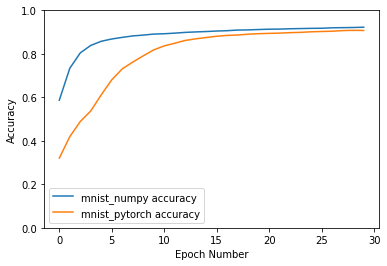

In [34]:
acc = []
for i,j in zip(accuracy['mnist_numpy'],accuracy['mnist_pytorch']):
  acc.append([i,j])
plt.plot(acc)
plt.legend(['mnist_numpy accuracy', 'mnist_pytorch accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

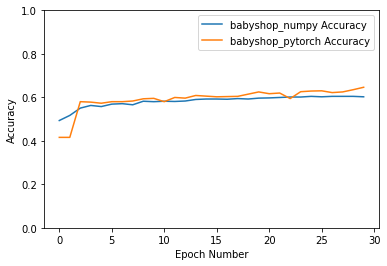

In [35]:
acc = []
for i,j in zip(accuracy['babyshop_numpy'],accuracy['babyshop_pytorch']):
  acc.append([i,j])
plt.plot(acc)
plt.legend(['babyshop_numpy Accuracy', 'babyshop_pytorch Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()